## PROYECTO FINAL

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import pathlib
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

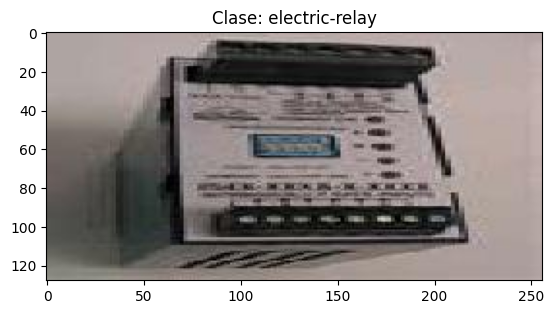

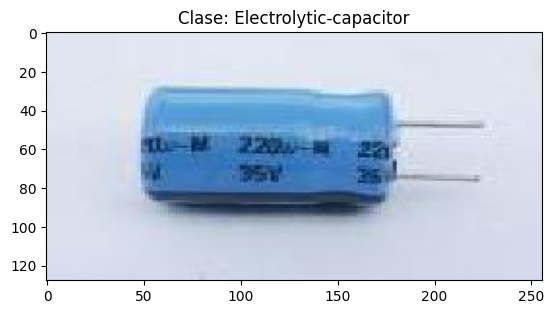

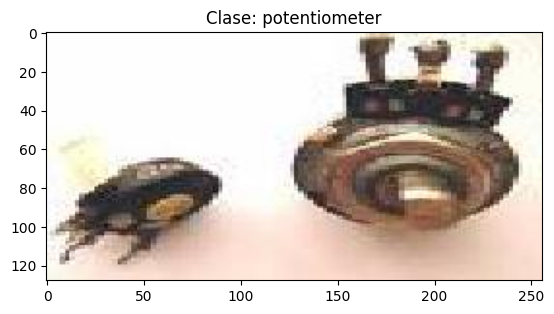

In [3]:
# Directorio donde se encuentran las carpetas de las clases
base_dir = 'DATASET'

# Obtiene una lista de las carpetas de clases
class_folders = [folder for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

# Itera sobre cada carpeta de clase
for folder in class_folders:
    class_dir = os.path.join(base_dir, folder)

    # Obtiene todos los archivos en la carpeta de la clase
    files = os.listdir(class_dir)

    # Selecciona el primer archivo (imagen)
    first_image_file = files[0]
    image_path = os.path.join(class_dir, first_image_file)

    # Carga la imagen
    image = Image.open(image_path)

    # Muestra la imagen con su etiqueta
    plt.imshow(image)
    plt.title(f"Clase: {folder}")
    plt.show()


## CARGA DE DATOS LOCALES

In [4]:
# Directorio donde se encuentran las carpetas de las clases
base_dir = 'DATASET'

# Obtiene una lista de las carpetas de clases
class_folders = [folder for folder in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, folder))]

# Inicializa un contador para el total de imágenes
total_images = 0

# Itera sobre cada carpeta de clase
for folder in class_folders:
    class_dir = os.path.join(base_dir, folder)

    # Obtiene todos los archivos en la carpeta de la clase
    files = [file for file in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, file))]

    # Cuenta el número de imágenes en la clase actual
    num_images = len(files)
    total_images += num_images

    # Muestra el número de imágenes en la clase actual
    print(f"Clase {folder}: {num_images} imágenes")

# Muestra el total de imágenes en todas las clases
print(f"Total de imágenes en todas las clases: {total_images}")


Clase electric-relay: 345 imágenes
Clase Electrolytic-capacitor: 382 imágenes
Clase potentiometer: 420 imágenes
Total de imágenes en todas las clases: 1147


In [5]:
base_dir = pathlib.Path(base_dir)
validation_split = 0.3
seed = 100
batch_size = 32
img_shape = (224, 224, 3)

data_training = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    labels="inferred",
    label_mode = "categorical",
    color_mode = "rgb", 
    batch_size = batch_size,
    image_size = (224, 224),
    shuffle = True, 
    seed = seed,
    validation_split = 0.2,
    subset = "training"
    )

data_validation = tf.keras.preprocessing.image_dataset_from_directory(
    base_dir,
    labels="inferred",
    label_mode = "categorical",
    color_mode = "rgb", 
    batch_size = batch_size,
    image_size = (224, 224),
    shuffle = True, 
    seed = seed,
    validation_split = 0.2,
    subset = "validation"
    )

Found 1147 files belonging to 3 classes.
Using 918 files for training.
Found 1147 files belonging to 3 classes.
Using 229 files for validation.


## MODELO 1 CONVOLUTIONAL NEURAL NETWORK (CNN)

In [21]:
# Tamaño de las imágenes
img_size = 224

modelito = keras.Sequential([
    # Capa de entrada
    keras.Input(shape=(img_size, img_size, 3)),

    # Preprocesamiento
    keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    keras.layers.experimental.preprocessing.RandomRotation(0.2),

    # Primera capa convolucional y MaxPooling
    keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.2),

    # Segunda capa convolucional y MaxPooling
    keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.3),

    # Tercera capa convolucional y MaxPooling
    keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.4),

    # Cuarta capa convolucional y MaxPooling
    keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Dropout(0.5),

    # Aplanado de la salida y capas densas
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),

    # Capa de salida
    keras.layers.Dense(3, activation='softmax')
])

modelito.summary()



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                      

In [22]:
modelito.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [23]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))

    # Gráfico de precisión (accuracy)
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()), 1])
    plt.title('Training and Validation Accuracy')

    # Gráfico de pérdida (loss)
    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.ylim([0, max(plt.ylim())])
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.show()


In [18]:
modelito.trainable = False
print('NUMERO DE VARIABLES ENTRENADAS  = {}'.format(len(modelito.trainable_variables)))

NUMERO DE VARIABLES ENTRENADAS  = 0


## ENTRENAMIENTO DEL PRIMER MODELO

In [26]:
grafica1 = modelito.fit(data_training, epochs=30, validation_data=data_validation)

Epoch 1/30


29/29 [==============================] - 10s 331ms/step - loss: 0.8672 - accuracy: 0.6383 - val_loss: 1.4648 - val_accuracy: 0.5459
Epoch 2/30
29/29 [==============================] - 9s 316ms/step - loss: 0.8257 - accuracy: 0.6394 - val_loss: 1.6364 - val_accuracy: 0.5328
Epoch 3/30
29/29 [==============================] - 9s 317ms/step - loss: 0.8137 - accuracy: 0.6514 - val_loss: 1.5016 - val_accuracy: 0.5808
Epoch 4/30
29/29 [==============================] - 9s 318ms/step - loss: 0.8362 - accuracy: 0.6416 - val_loss: 1.5571 - val_accuracy: 0.5546
Epoch 5/30
29/29 [==============================] - 9s 320ms/step - loss: 0.8208 - accuracy: 0.6460 - val_loss: 1.3021 - val_accuracy: 0.5808
Epoch 6/30
29/29 [==============================] - 9s 315ms/step - loss: 0.7393 - accuracy: 0.6808 - val_loss: 1.2661 - val_accuracy: 0.5677
Epoch 7/30
29/29 [==============================] - 9s 316ms/step - loss: 0.7306 - accuracy: 0.6885 - val_loss: 1.5201 - val_accuracy: 0.5677
Epoch 8/30
29/29

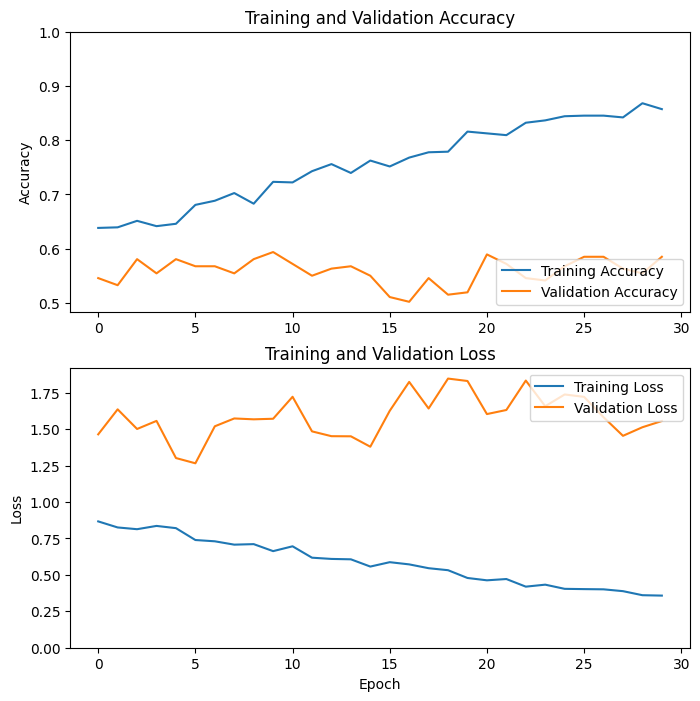

In [27]:
plot_training_history(grafica1)

In [28]:
def plot_confusion_matrix(model, data_validation):
    # Obtener las etiquetas reales y predicciones del modelo
    y_true = []
    y_pred = []

    # Obtener los nombres originales de las clases
    class_names = data_validation.class_names

    for images, labels in data_validation:
        predictions = model.predict(images)
        y_true.extend(np.argmax(labels, axis=1))
        y_pred.extend(np.argmax(predictions, axis=1))

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_true, y_pred)

    # Mostrar la matriz de confusión utilizando seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Mostrar el informe de clasificación
    print(classification_report(y_true, y_pred, target_names=class_names))

1/1 [==============================] - 0s 29ms/step


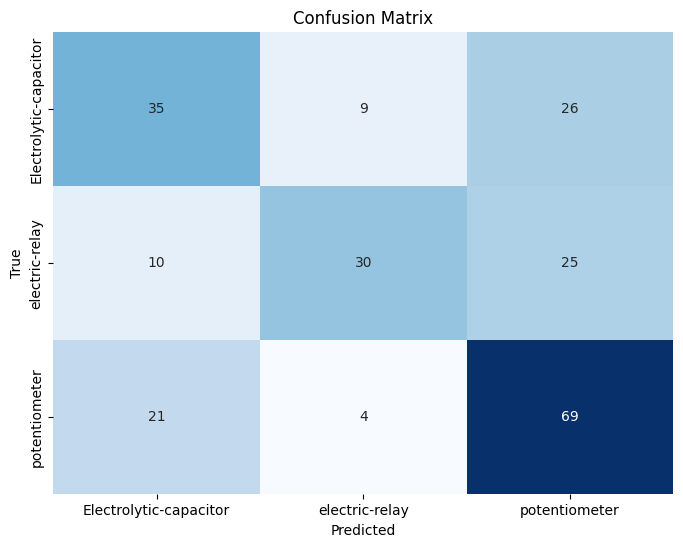

                        precision    recall  f1-score   support

Electrolytic-capacitor       0.53      0.50      0.51        70
        electric-relay       0.70      0.46      0.56        65
         potentiometer       0.57      0.73      0.64        94

              accuracy                           0.59       229
             macro avg       0.60      0.57      0.57       229
          weighted avg       0.60      0.59      0.58       229



In [33]:
plot_confusion_matrix(modelito, data_validation)

## MODELO 2 TRANSFER LEARNING (VGG16)

In [12]:
tf.keras.applications.vgg16.preprocess_input

<function keras.applications.vgg16.preprocess_input(x, data_format=None)>

In [13]:
modelito2 = tf.keras.applications.vgg16.VGG16(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')

In [14]:
modelito2 = tf.keras.Sequential([
    tf.keras.Input(shape = (img_size, img_size, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    modelito2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [15]:
modelito2.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

modelito2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 14,716,227
Trainable params: 14,716,227


## ENTRENAMIENTO FALLIDO :(

In [16]:
grafica2 = modelito2.fit(data_training, epochs= 10, validation_data=data_validation)

Epoch 1/10


 9/29 [========>.....................] - ETA: 28s - loss: 2.3346 - accuracy: 0.3472

ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_1/vgg16/block1_conv2/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "c:\Users\emanu\miniconda3\envs\inte\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\emanu\miniconda3\envs\inte\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\traitlets\config\application.py", line 1077, in launch_instance
      app.start()
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\ipykernel\kernelapp.py", line 737, in start
      self.io_loop.start()
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\emanu\miniconda3\envs\inte\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\emanu\miniconda3\envs\inte\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\emanu\miniconda3\envs\inte\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\ipykernel\kernelbase.py", line 524, in dispatch_queue
      await self.process_one()
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\ipykernel\kernelbase.py", line 513, in process_one
      await dispatch(*args)
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\ipykernel\kernelbase.py", line 418, in dispatch_shell
      await result
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\ipykernel\kernelbase.py", line 758, in execute_request
      reply_content = await reply_content
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\ipykernel\ipkernel.py", line 426, in do_execute
      res = shell.run_cell(
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell
      result = self._run_cell(
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell
      result = runner(coro)
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\emanu\AppData\Local\Temp\ipykernel_13676\1763758584.py", line 1, in <module>
      grafica2 = modelito2.fit(data_training, epochs= 10, validation_data=data_validation)
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\emanu\miniconda3\envs\inte\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_1/vgg16/block1_conv2/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[32,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_1/vgg16/block1_conv2/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_12362]

## CONCLUSIONES
Se realizaron 2 modelos para un dataset de 3 clases que clasificaban entre 3 tipos de componentes electronicos (rele, potenciometro y capacitor) cabe recalcar que antes se tenia otro dataset que tenias diferentes tipos de componentes electronicos (Resistencia, capacitor y IC) al tener diferentes tipos de extensiones los modelos no podian hacer inferencia.
El primer modelo fue uno realizado capa por capa con un accuracy de 59,6% y mi segundo modelo fue un intento de Transfer Learning para la arquitectura VGG16 pero no se pudo completar el entrenamiento debido a falta de memoria en mi GPU.